In [1]:
import pandas as pd
import urllib.request, json 
from urllib.error import HTTPError
import numpy as np
import igraph as ig
import easygui
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import wordcloud 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
with urllib.request.urlopen("https://codex.opendata.api.vlaanderen.be:443/api/Trefwoord") as url:
    print("df")
    data = json.load(url)
    print(data)

df
{'TotaalAantal': 2330, 'ResultatenLijst': [{'Naam': 'taalgebruik', 'Link': {'Rel': 'self', 'Href': 'https://codex.opendata.api.vlaanderen.be/api/Trefwoord/1000001'}, 'Id': 1000001}, {'Naam': 'Promotie Landbouw, Tuinbouw en Zeevisserijproducten vzw.', 'Link': {'Rel': 'self', 'Href': 'https://codex.opendata.api.vlaanderen.be/api/Trefwoord/1000002'}, 'Id': 1000002}, {'Naam': 'Vlaams Fonds promotie producten landbouw/tuinbouw/zeevisserij', 'Link': {'Rel': 'self', 'Href': 'https://codex.opendata.api.vlaanderen.be/api/Trefwoord/1000003'}, 'Id': 1000003}, {'Naam': 'Vlaamse dienst voor agro-marketing', 'Link': {'Rel': 'self', 'Href': 'https://codex.opendata.api.vlaanderen.be/api/Trefwoord/1000004'}, 'Id': 1000004}, {'Naam': 'VLAM', 'Link': {'Rel': 'self', 'Href': 'https://codex.opendata.api.vlaanderen.be/api/Trefwoord/1000005'}, 'Id': 1000005}, {'Naam': 'Vlaams Promotiecentrum voor Agro- en Visserijmarketing', 'Link': {'Rel': 'self', 'Href': 'https://codex.opendata.api.vlaanderen.be/api/Tre

In [3]:
# get the IDs of all the trefworden

trefwoord_ids = []
trefwoord_names = []

for item in data["ResultatenLijst"]:
    trefwoord_ids.append(item["Id"])
    trefwoord_names.append(item["Naam"])

In [4]:
df_keyeyword = pd.DataFrame({"key_id":trefwoord_ids, "key_name":trefwoord_names})
# df_keyeyword['key_id'] = df_keyeyword.index
df_keyeyword.to_csv("./db data/key_df.csv", index = False)

<h1> Documents </h1>

In [96]:
# get the corresponding documents and their attributes

doc_ids = []
doc_title = []
doc_type = []
doc_date = []
for id in trefwoord_ids:
    with urllib.request.urlopen(f"https://codex.opendata.api.vlaanderen.be:443/api/Trefwoord/{id}/WetgevingDocumenten") as url:
        data = json.load(url)
        for i in data["ResultatenLijst"]:
            doc_ids.append(i["Id"])
            doc_title.append(i["Opschrift"])
            doc_type.append(i["WetgevingDocumentType"])
            doc_date.append(i["Datum"])

# 3838 documents

In [137]:
# creating doc df
df_docsoc =pd.DataFrame()
df_docsoc["id"] = doc_ids
df_docsoc["about"] = doc_title
df_docsoc["date"] = doc_date
df_docsoc["type"] = doc_type

df_docsoc["date"]= pd.to_datetime(df_docsoc["date"])
df_docsoc["year"] = df_docsoc["date"].dt.year
df_docsoc["month"] = df_docsoc["date"].dt.month
df_docsoc["day"] = df_docsoc["date"].dt.day

In [10]:
# creating date df
df_docsoc= pd.read_csv("./db data/date.csv")
df_docsoc["date"]= pd.to_datetime(df_docsoc["date"])
df_docsoc["year"] = df_docsoc["date"].dt.year
df_docsoc["month"] = df_docsoc["date"].dt.month
df_docsoc["day"] = df_docsoc["date"].dt.day

df_docsoc.to_csv("./db data/date.csv", index = False)

In [11]:
# creating keyword -doc rel df

doc_ids= []
keyword_ids=[]
for id in df_keyeyword["key_id"]:
    try:
        with urllib.request.urlopen(f"https://codex.opendata.api.vlaanderen.be:443/api/Trefwoord/{id}/WetgevingDocumenten") as url:
            data = json.load(url)
            for doc_id in data["ResultatenLijst"]:
                doc_ids.append(doc_id["Id"])
                keyword_ids.append(id)
    except urllib.error.HTTPError:
        doc_ids.append("unknown")
        continue


In [13]:
df_rel_key_doc = pd.DataFrame()
df_rel_key_doc["key_id"] = keyword_ids
df_rel_key_doc["doc_id"] = doc_ids
df_rel_key_doc["rel"] = "keyword"
df_rel_key_doc.to_csv("./db data/df_rel_key_doc.csv", index = False)

In [19]:
doc_ids_df = pd.read_csv("./db data/docs.csv")

In [14]:
with urllib.request.urlopen(f"https://codex.opendata.api.vlaanderen.be:443/api/WetgevingDocument/1000001/DocumentRelaties") as url:
    data = json.load(url)
    print(data)

{'TotaalAantal': 1, 'ResultatenLijst': [{'WetgevingDocumentId': 1014319, 'Opschrift': 'houdende wijziging van de Gemeentekieswet, gecoördineerd op 4 augustus 1932, de wet van 19 oktober 1921 tot regeling van de provincieraadsverkiezingen en het decreet van 18 mei 1994 houdende regeling van het taalgebruik bij de verkiezingen', 'Datum': '2006-02-10T00:00:00', 'BSDatum': '2006-02-28T00:00:00', 'BSPagina': 12164, 'RelatieType': 'Gewijzigd bij', 'RelatieTypeId': 6, 'WetgevingDocumentType': 'Decreet', 'HeeftInhoud': False, 'Link': {'Rel': 'self', 'Href': 'https://codex.opendata.api.vlaanderen.be/api/WetgevingDocument/1000001/DocumentRelaties/1000001'}, 'Id': 1000001}]}


In [15]:
# Get document relationships
source_id= []
target_id=[]
rel = []
for id in doc_ids:
    try:
        with urllib.request.urlopen(f"https://codex.opendata.api.vlaanderen.be:443/api/WetgevingDocument/{id}/DocumentRelaties") as url:
            data = json.load(url)
            for doc_id in data["ResultatenLijst"]:
                target_id.append(doc_id["WetgevingDocumentId"])
                source_id.append(id)
                rel.append(doc_id["RelatieType"])
    except urllib.error.HTTPError:
        target_id.append("unknown")
        rel.append("unknown")
        continue

In [17]:
df_rel_doc_doc = pd.DataFrame()
df_rel_doc_doc["source_id"] = source_id
df_rel_doc_doc["target_id"] = target_id
df_rel_doc_doc["rel"] = rel
# df_rel_doc_doc.to_csv("df_rel_doc_doc.csv", index = False)

In [11]:
# remove double-connected nodes 
copy = df_rel_doc_doc.copy()
filter_df = pd.DataFrame()
for source, target, rel in zip(df_rel_doc_doc["source_id"], df_rel_doc_doc["target_id"], df_rel_doc_doc["rel"]):
    copy = copy.drop(copy[(copy["source_id"] == target) & (copy["target_id"] == source)].index)
    # filter_df.append(filter, ignore_index=True)
copy.drop_duplicates(inplace=True)


In [12]:
copy.to_csv("./db data/df_rel_doc_doc.csv", index = False)

check which documents are missing

In [16]:
df_rel_doc_doc = pd.read_csv("./db data/df_rel_doc_doc.csv")

In [20]:
id_rel = df_rel_doc_doc["doc_id"].unique().tolist()
id_rel_t = df_rel_doc_doc["target_id"].unique().tolist()

list = id_rel+id_rel_t
df = doc_ids_df["id"].unique().tolist()
result = [x for x in list if x not in df]

In [21]:
missing_docs = result

add missing docs

In [ ]:
doc_ids = []
doc_title = []
doc_type = []
doc_date = []
doc_link = []

for id in missing_docs:
    with urllib.request.urlopen(f"https://codex.opendata.api.vlaanderen.be:443/api/WetgevingDocument/{id}") as url:
        data = json.load(url)
        doc_ids.append(data["Id"])
        doc_title.append(data["Opschrift"])
        doc_type.append(data["WetgevingDocumentType"])
        doc_date.append(data["Datum"])
        doc_link.append(data["Link"]["Href"])


In [27]:
df_docsoc =pd.DataFrame()
df_docsoc["id"] = doc_ids
df_docsoc["about"] = doc_title
df_docsoc["date"] = doc_date
df_docsoc["type"] = doc_type
df_docsoc["link"] = doc_link

In [38]:
links = doc_date
links = links[1::2]
date = [x for x in doc_date if x not in links]
df_docsoc =pd.DataFrame()
df_docsoc["id"] = doc_ids
df_docsoc["about"] = doc_title
df_docsoc["date"] = date
df_docsoc["type"] = doc_type
df_docsoc["link"] = links

In [39]:
result = pd.concat([df_docsoc, doc_ids_df], ignore_index=True)

In [40]:
result.to_csv("./db data/docs.csv", index = False)

<h1> Articles </h1>

In [ ]:
# get articles ids (not the versions, just articles)
art_ids = []
doc_ids = []
for id in doc_ids_df:
    try:
        with urllib.request.urlopen(f"https://codex.opendata.api.vlaanderen.be:443/api/WetgevingDocument/{id}/VolledigDocument") as url:
            data = json.load(url)
            for art_id in data["Inhoud"]["Artikelen"]:
                doc_ids.append(id)
                art_ids.append(art_id["Id"])
    except urllib.error.HTTPError:
        art_ids.append("unknown")
        continue

art_ids[:5] #URLError: <urlopen error [WinError 10053] An established connection was aborted by the software in your host machine>


In [43]:
# DF articles 
df_art_ids = pd.DataFrame()
df_art_ids["art_id"] = art_ids
df_art_ids.to_csv("./db data/df_art_ids.csv", index = False)

In [44]:
# DFs document and articles 
df_rel_doc_art = pd.DataFrame()
df_rel_doc_art["doc_id"] = doc_ids
df_rel_doc_art["art_id"] = art_ids
df_rel_doc_art["rel"] = "article"
df_rel_doc_art.to_csv("./db data/df_rel_doc_art.csv", index = False)

In [2]:
df =pd.read_csv("./db data/df_art_ids.csv")
art_ids = df["art_id"]

<h1> Articles version </h1>

In [ ]:
art_v_ids = []
for id in art_ids:
    try:
        with urllib.request.urlopen(f"https://codex.opendata.api.vlaanderen.be:443/api/WetgevingArtikel/{id}/Versies") as url:
            data = json.load(url)
            if data["TotaalAantal"] > 1:
                art_v_ids.append("no versions")
            else:
                list_v_ids = []
                for i in data["ResultatenLijst"]: 
                    list_v_ids.append(i["Id"])
                art_v_ids.append(list_v_ids)

    except urllib.error.HTTPError:
        art_ids.append("unknown")
        continue

In [4]:
df_art_v = pd.DataFrame()
df_art_v["art_v_id"] = art_v_ids
df_art_v.to_csv("./db data/df_art_v.csv", index = False)

In [7]:
df_art_v = pd.read_csv("./db data/df_art_v.csv") # !!!!! remove brackets in the file

In [ ]:
# get article versions attributes 140 min
art_v_start_date = []
art_v_end_date = []
art_v_title = []

for id in df_art_v["art_v_id"]:
    print(id)
    if id == "no versions":
        continue
    else:
        # try:
        with urllib.request.urlopen(f"https://codex.opendata.api.vlaanderen.be:443/api/WetgevingArtikelVersie/{id}/VolledigeArtikelVersie") as url:
            data = json.load(url)
            art_v_start_date.append(data["Document"]["StartDatum"])
            art_v_end_date.append(data["Document"]["EindDatum"])
            art_v_title.append(data["Document"]["Opschrift"])

In [9]:
# check for articles that have versions (to article version df)
df_art_v = df_art_v[df_art_v.art_v_id != "no versions"]
df_art_v["startdate"] = art_v_start_date
df_art_v["enddate"] = art_v_end_date
df_art_v["title"]= art_v_title
df_art_v.to_csv("./db data/df_article_versions_ids.csv", index = False)

In [10]:
# article and article versions links
df_art_artv = pd.DataFrame()
df_art_artv["article_id"]  = art_ids
df_art_artv["article_v_id"]  = df_art_v["art_v_id"]
df_art_artv["rel"]  = "version"
df_art_artv = df_art_artv[df_art_artv.article_v_id != "no versions"]

df_art_artv.to_csv("./db data/df_rel_art_artv.csv", index = False)

In [11]:
df_art_artv = pd.read_csv("./db data/df_rel_art_artv.csv")

In [12]:
df_art_artv = df_art_artv.dropna(axis = 0)

In [13]:
df_art_artv.to_csv("./db data/df_rel_art_artv.csv", index = False)

<h1> Graph analysis </h1>

In [4]:
# preparing data for graph analysis 
df = pd.read_csv("./db data/df_rel_doc_doc.csv")

In [18]:
network = ig.Graph.TupleList(df.itertuples(index=False), directed=False, weights=False)

In [6]:
cc= network.connected_components(mode='WEAK')
print("number of connected components " + str(len(cc)))
cc = np.array(sorted(cc, key=len, reverse=True), dtype="object")
print("largest component is " + str(len(cc[0])) + " nodes big")
print("second largest component is " + str(len(cc[1])) + " nodes big")

number of connected components 585
largest component is 7963 nodes big
second largest component is 25 nodes big


In [23]:
network = network.subgraph(cc[0])

In [24]:
nodes = network.vcount()
perm=np.random.permutation(nodes).tolist()
perm_network = network.permute_vertices(perm)

In [25]:
com = perm_network.community_multilevel(resolution=1.3, return_levels=False)

Random walk

In [26]:
rw = perm_network.community_walktrap(steps = 50) 
rw = rw.as_clustering()

Leiden

In [27]:
leiden = perm_network.community_leiden(resolution=1.3)

X Eigenvalue X

In [ ]:
lead = perm_network.community_leading_eigenvector() #  Error at src/community/leading_eigenvector.c:563: ARPACK did not converge. -- No eigenvalues to sufficient accuracy 

<h1> Validation </h1>

In [30]:
print(ig.compare_communities(com, rw, method='nmi'))
print(ig.compare_communities(com, leiden, method='nmi'))
print(ig.compare_communities(rw, leiden, method='nmi'))


0.7565659292425088
0.5784532956582464
0.5809659997403537


In [85]:
print(len(set(com.membership)))
print(len(set(rw.membership)))
print(len(set(leiden.membership)))

56
130
7881


In [32]:
# create a dataframe with communities and node IDs
multilevel_df = pd.DataFrame(data={'ID':perm_network.vs()['name'],'cluster':com.membership})
rw_df = pd.DataFrame(data={'ID':perm_network.vs()['name'],'cluster':rw.membership})
leiden_df = pd.DataFrame(data={'ID':perm_network.vs()['name'],'cluster':leiden.membership})

Note: some documents belong to multiple key words, while the cluster assignment is unique (a node cannot appear in two clusters). Hence, this method of validation is not ideal. 

In [47]:
df_rel_key = pd.read_csv("./db data/df_rel_key_doc.csv")
df_key =  pd.read_csv("./db data/key_df.csv")
df_docs = pd.read_csv("./db data/docs.csv")

def cluster_validation(df_rel_key, df_key, df_docs, model_df, csv_name):

    # merge DataFrame with communities and document properties
    df_rel_key = df_rel_key.rename({"doc_id":"ID"}, axis = 1)
    df_final = pd.merge(model_df, df_rel_key, on = "ID")
    df_final2 = pd.merge(df_final,df_key, on = "key_id" )

    df_docs = df_docs.rename({"id":"ID"}, axis = 1)
    df2 = pd.merge(model_df,df_docs, on = "ID") # complete df with cluster
    df2 = df2.dropna(subset=["year", "month", "day"], how='all')
    df2 = df2.drop_duplicates()


    df2.to_csv(f"{csv_name}_doc_cluster.csv", index = False)
    df_final2.to_csv(f"{csv_name}_com_analysis.csv", index = False)
    return df2, df_final2


multilevel2, multilevel3 = cluster_validation(df_rel_key, df_key, df_docs, multilevel_df, "./analysis/multilevel_df")
rw2, rw3 = cluster_validation(df_rel_key, df_key, df_docs, rw_df, "./analysis/rw_df")
leiden2, leiden3 = cluster_validation(df_rel_key, df_key, df_docs, leiden_df, "./analysis/leiden_df")


Investigate:
- how many keywords have 1 cluster only (unique mapping)
- how many keywords belong to more than one cluster
- how many clusters include more than one keyword

In [88]:
# count how many documents are in each key word
g1 = rw3.groupby(['key_name', "cluster"])[["ID"]].count()
g1 = g1.add_suffix('_Count').reset_index()
count = g1.value_counts("key_name").rename_axis('unique_values').reset_index(name='counts')

In [89]:
# how many keywords have 1 cluster only (unique mapping)
# how many keywords belong to more than one cluster
# how many clusters include more than one keyword
unique_keys = g1["key_name"].unique()

count_keys_morecl = []
count_unique = []
for i in unique_keys:
    if g1["key_name"].value_counts()[i] > 1:
        df = g1[g1["key_name"] == i]
        length = len(df)
        if length > 1:
            count_keys_morecl.append(1)
    else:
        df = g1[g1["key_name"] == i]
        # get the cluster
        cluster = df["cluster"].unique()
        # subset the df with that cluster
        df2 = g1[g1["cluster"] == cluster[0]] 
        if len(df2) == 1:
            print(df2)
            count_unique.append(1)
print(len(count_keys_morecl)) 
len(count_unique) 

           key_name  cluster  ID_Count
137  Vlaams-Brabant       44         1
171


1

In [95]:
unique_cl = g1["cluster"].unique()

count_keys = []
cluster_ids = []
for i in unique_cl:
    if g1["cluster"].value_counts()[i] > 1:
        df = g1[g1["cluster"] == i]
        length = len(df)
        cluster_ids.append(i)
        if length > 1:
            count_keys.append(1)
len(count_keys)    

99

Explore the topics of each cluster
- it is possible that community detection aggregates similar keywords

(-0.5, 1599.5, 799.5, -0.5)

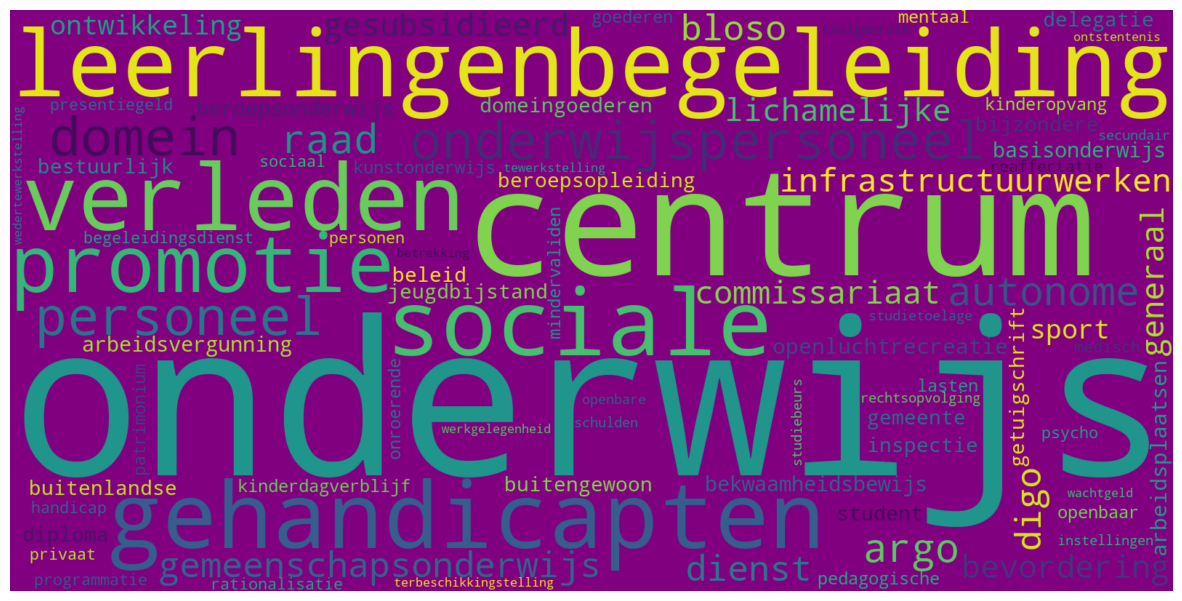

In [135]:
with open("stop_words_dutch.txt", "r") as f:
    stopwords_into_list  = [line[:-1] for line in f]
    stopwords_into_list.append("vlaamse")
    stopwords_into_list.append("vlaams")
    stopwords_into_list.append("statuut")
    stopwords_into_list.append("plan")
    stopwords_into_list.append("instituut")

t1 = g1[g1["cluster"] == cluster_ids[2]]
word_string=" ".join(t1["key_name"].str.lower())

plt.figure(figsize=(15,15))
wc = WordCloud(background_color="purple", stopwords = stopwords_into_list, max_words=2000, max_font_size= 300,  width=1600, height=800)
wc.generate(word_string)

plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), interpolation="bilinear")
plt.axis('off')